# Explaining notes:

- Mesh is imported then the kernel function is defined on the mesh using the package. 
- Then regular discretised BO is done on the mesh's nodes. 
- You can change all the parameters of:
   - The Bayesian optimisation loop: num_iterations etc.
   - The acquisition function (it's EI): exploration, exploitation etc..
   - The mesh kernel. 
- The plotly thing shows traces which can be shown and hidden by clicking on them. For this case each trace is one of the "functions" (i.e nx1 vectors where n is the number of nodes in the mesh) applied to the mesh.
- You can switch between the "chemistry" function and the dummy function when doing the torus but I don't think there's anything interesting. 
- the torus mesh is a bit weird and so the algorithm never explores the inside of the torus, but it does fine for the teddy bear mesh




Contents of this ipynb:
- Doing BO on the mesh. Showing with two different BO loops (and then plotting the posterior mu_1, mu_2 functions respectively). You can tweak the number of iterations that each do 
- Visualisation of the kernel spreading covariance throughout the shape. 

## Importing everything

In [3]:
!pip install pymanopt matplotlib ipympl kaleido plotly scipy rdkit 


import numpy as np
import random
from scipy.stats import norm
import geometric_kernels
from geometric_kernels.spaces import Mesh
from geometric_kernels.kernels import MaternGeometricKernel, MaternKarhunenLoeveKernel
import matplotlib as mpl
import matplotlib.pyplot as plt
import kaleido
import plotly
import plotly.io as pio
pio.renderers.default = "browser" # "browser" opens in browser. "vscode" in vscode (for the notebook version; doesn't work with py) 
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from Plotting import *
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdMolTransforms, Descriptors
from rdkit.Chem import rdMolTransforms
# import matplotlib 
# import matplotlib.pyplot as plt
# # !pip install ipympl
# import ipympl
# %matplotlib notebook
from rdkit import Chem
from rdkit.Chem import rdMolTransforms

## Chemistry-specific stuff

In [4]:
def set_double_torsion_and_get_energy(molecule, angle1, angle2):
    """
    Set two torsion angles and return minimized energy.
    """
    mol = Chem.Mol(molecule)
    
    # Find rotatable bonds
    rotatable_bonds = mol.GetSubstructMatches(
        Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]')
    )
    
    if len(rotatable_bonds) < 2:
        return None
    
    conform = mol.GetConformer()
    angles = [angle1, angle2]
    
    # Set both torsion angles directly first
    for idx, bond in enumerate(rotatable_bonds[:2]):
        i, j = bond
        i_neighbours = [n.GetIdx() for n in mol.GetAtomWithIdx(i).GetNeighbors() 
                       if n.GetIdx() != j][0]
        j_neighbours = [n.GetIdx() for n in mol.GetAtomWithIdx(j).GetNeighbors() 
                       if n.GetIdx() != i][0]
        rdMolTransforms.SetDihedralDeg(conform, i_neighbours, i, j, j_neighbours, 
                                       angles[idx])
    
    # Now create force field and minimize with constraints
    props = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94')
    ff = AllChem.MMFFGetMoleculeForceField(mol, props)
    
    # Add torsion constraints for both bonds
    for idx, bond in enumerate(rotatable_bonds[:2]):
        i, j = bond
        i_neighbours = [n.GetIdx() for n in mol.GetAtomWithIdx(i).GetNeighbors() 
                       if n.GetIdx() != j][0]
        j_neighbours = [n.GetIdx() for n in mol.GetAtomWithIdx(j).GetNeighbors() 
                       if n.GetIdx() != i][0]
        ff.MMFFAddTorsionConstraint(i_neighbours, i, j, j_neighbours, 
                                    False, angles[idx] - 0.5, angles[idx] + 0.5, 
                                    1000.0)
    
    ff.Minimize()
    return ff.CalcEnergy()


pentane = Chem.MolFromSmiles('CCCCC')
AllChem.EmbedMolecule(pentane)



[14:14:20] Molecule does not have explicit Hs. Consider calling AddHs()


0

## Mesh and kernel set up

In [5]:
MeshFolder_dir = Path.cwd() #/ "My meshes"
print( "DIR:", MeshFolder_dir)
Filename = "Delaunay 100point sphere.obj"
mesh = Mesh.load_mesh(str(MeshFolder_dir / Filename))
print(mesh.num_vertices)


#Kernel stuff:
kernel = MaternGeometricKernel(mesh)

LENGTH_SCALE,NU = 4, 0.5
VARIANCE = "NEEDS_CONFIGURING"  #variance isn't part of the package but it can be "easily implemented" by multiplying the kernel by a constant and then optimising for it





DIR: c:\Users\aum39\OneDrive\Desktop\Research project current SOP\Sphere example for Hybrid Bayesian optimisation\Main


RuntimeError: couldn't open file c:\Users\aum39\OneDrive\Desktop\Research project current SOP\Sphere example for Hybrid Bayesian optimisation\Main\Delaunay 100point sphere.obj

## Objective functions (choose one)


In [ ]:
params = kernel.init_params()
params["lengthscale"] = np.array([LENGTH_SCALE])
params["nu"] = np.array([NU])

In [ ]:
def actual_chemical_f(x): #return this immediately TODO: reutnr 
    #x is a node index.
    if isinstance(x, np.ndarray):
        x = x.flatten()

    rho, theta = divmod(x, 360)
    rho, theta = int(rho), int(theta)
    # rho, theta = theta, rho #TODO: delete immediately
    return set_double_torsion_and_get_energy(pentane, rho, theta)

def f(x):
    #assuming that x is a node index.
    if isinstance(x, np.ndarray): euclidean_coord =  mesh.vertices[np.int64(x.flatten()) -1].flatten()
    else:
        euclidean_coord = mesh.vertices[x-1]
    return euclidean_coord[0]
    # return np.array(3)
j = np.vectorize(f)

## BO setup

In [ ]:
def expected_improvement(mu, sigma, f_best, xi=0.0):
    """
    Calculates the Expected Improvement (EI) for a set of points.

    Args:
        mu (np.ndarray): The posterior mean vector.
        sigma (np.ndarray): The posterior standard deviation vector.
        f_best (float): The best observed function value.
        xi (float): The exploration-exploitation trade-off parameter.

    Returns:
        np.ndarray: The EI vector.
    """
    # Calculate the standardized improvement (Z)
    xi = 0.9
    with np.errstate(divide='ignore'):  # suppress divide by zero warning
        
        mu = mu.reshape(-1,1) # TODO: delete this if it causes issues. 
        sigma = sigma.reshape(-1,1)
        Z = (f_best - mu - xi) / sigma #TODO: this and the one below may be the wrong expression. 
        
    # Calculate the EI for non-zero sigma
    ei = (f_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    # Handle the case where sigma is zero
    ei = np.where(sigma > 1e-10, ei, 0.0)
    
    return ei


def BO_loop_fixed(num_iterations, x_obs=None, objective_func=None, 
                  exploration_weight=0.1):
    """
    Fixed BO loop with better exploration of inner torus surface.
    
    Args:
        exploration_weight: Add random exploration with this probability
    """
    if objective_func is None:
        objective_func = f
    if x_obs is None:
        x_obs = x_observed

    num_verts = mesh.num_vertices
    whole_domain = np.atleast_2d(np.arange(1, num_verts + 1)).T

    y_observed = np.atleast_2d(np.apply_along_axis(objective_func, 1, x_obs)).reshape(-1, 1)
    K_XX_prior = kernel.K(params, whole_domain - 1, whole_domain - 1)
    mu_prior_vector = np.zeros((num_verts, 1))

    exploration_points = []

    for i in range(num_iterations):
        # GP Model Fitting
        m_vector = mu_prior_vector[x_obs.flatten() - 1]
        K_xX = kernel.K(params, x_obs - 1, whole_domain - 1)
        K_xx = kernel.K(params, x_obs - 1, x_obs - 1)
        K_Xx = K_xX.T
        
        K_xx_stable = K_xx + np.eye(K_xx.shape[0]) * 1e-6
        C_inv = np.linalg.pinv(K_xx_stable)

        mew_vec = mu_prior_vector + K_Xx @ C_inv @ (y_observed - m_vector)
        Current_K_matrix = K_XX_prior - K_Xx @ C_inv @ K_xX
        Sigma_vec = np.diag(Current_K_matrix).copy().reshape(-1, 1)
        Sigma_vec[Sigma_vec < 0] = 0 

        # Acquisition Function
        EI_vec = expected_improvement(mew_vec, np.sqrt(Sigma_vec), np.min(y_observed))
        
        
        next_point = np.argmax(EI_vec) + 1
        
        next_point = np.atleast_2d(next_point)

        # Update
        y_next = np.atleast_2d(objective_func(next_point - 1))
        x_obs = np.vstack((x_obs, next_point))
        y_observed = np.vstack((y_observed, y_next))

    
    return mew_vec, Sigma_vec, EI_vec, x_obs, y_observed

## BO 

In [ ]:
objective_vals = j(np.arange(0, mesh.num_vertices, 1))
pio.renderers.default = "browser"

objective_plot_kwargs = dict(
    name = "objective value",
    marker = dict(
        size = 10,
        colorscale = 'hot'
    )
)
objective_trace = vector_values_to_mesh_trace(mesh, objective_vals, **objective_plot_kwargs)
hover_kwargs = dict(
    customdata = np.hstack([np.atleast_2d(objective_vals).T, np.atleast_2d(np.arange(1, mesh.num_vertices + 1)).T]),
    hovertemplate = ("x : %{x:.2f}<br>" + "y : %{y:.2f}<br>" + "z : %{z:.2f}<br>" + "objective value: %{customdata[0]:.2f}<br>" + "node index: %{customdata[1]}"),
)
objective_trace = add_custom_hover_data(objective_trace, **hover_kwargs)



# plot 2 different results (posterior mean, posterior stdev, x observed, y observed) with 2 different num_iterations


initial_point = np.array ([[np.random.randint(1, mesh.num_vertices)]])
mu_1, sigma_1, ei_1, X_1, Y_1 = BO_loop_fixed(1, x_obs = initial_point, objective_func = f)
mu_2, sigma_2, ei_2, X_2, Y_2 = BO_loop_fixed(5,x_obs = initial_point,  objective_func = f)
mu_3, sigma_3, ei_3, X_3, Y_3 = BO_loop_fixed(10,x_obs = initial_point,  objective_func = f)

advanced_fig = go.Figure()

mu_1_trace = vector_values_to_mesh_trace(mesh, mu_1)
mu_2_trace = vector_values_to_mesh_trace(mesh, mu_2)
mu_3_trace = vector_values_to_mesh_trace(mesh, mu_3)
mu_2_trace = add_custom_hover_data(mu_2_trace, customdata = mu_2)
mu_1_trace = add_custom_hover_data(mu_1_trace, customdata = mu_1)
mu_3_trace = add_custom_hover_data(mu_3_trace, customdata = mu_3)

advanced_fig.add_trace(mu_1_trace)
advanced_fig.add_trace(mu_2_trace)
advanced_fig.add_trace(mu_3_trace)
advanced_fig.add_trace(objective_trace)




####plotting the points explored by the algoritjm

euclidean_coord_of_point_plotted = mesh.vertices[np.int64(X_2.flatten()-1)]
third_euclidean_coord_of_point_plotted = mesh.vertices[np.int64(X_3.flatten()-1)]
point_plot_trace = go.Scatter3d(
    x = np.array(euclidean_coord_of_point_plotted[:,0]),
    y = np.array(euclidean_coord_of_point_plotted[:,1]),
    z = np.array(euclidean_coord_of_point_plotted[:,2]),
    marker = dict(
        color = "cyan"
    ),
    mode = "markers"
)

second_point_plot_trace = go.Scatter3d(
    x = np.array(third_euclidean_coord_of_point_plotted[:,0]),
    y = np.array(third_euclidean_coord_of_point_plotted[:,1]),
    z = np.array(third_euclidean_coord_of_point_plotted[:,2]),
    marker = dict(
        color = "purple"
    ),
    mode = "markers"
)

advanced_fig.add_trace(point_plot_trace)
advanced_fig.add_trace(second_point_plot_trace)



fig_show(advanced_fig) #TODO: add this back

print("the sampled values are (sorted ascending)", sorted(list(Y_2)), ".While the true best is", np.min(objective_vals), "which is at index:", np.argmax(-1*objective_vals))
print("the initial point's value is", objective_vals[initial_point.squeeze()])







the sampled values are (sorted ascending) [array([-0.84320253]), array([-0.60336839]), array([-0.2113735]), array([0.17486225]), array([0.28635786]), array([0.62115073])] .While the true best is -0.9548198955585642 which is at index: 96
the initial point's value is -0.8432025307109571


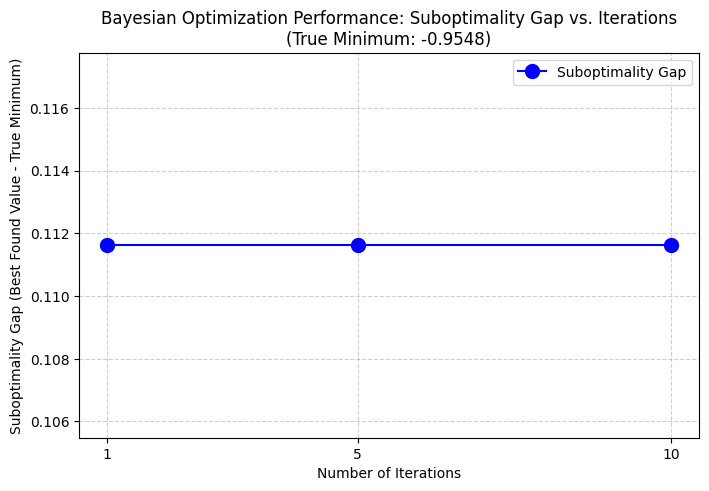

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Code to be added ---

# 1. Define the number of iterations
iterations = [1, 5, 10]

# 2. Calculate the true minimum (assuming objective_vals is defined)
true_min = np.min(objective_vals)

# 3. Calculate the best found value for each run (assuming Y_1, Y_2, Y_3 are defined)
best_found_1 = np.min(Y_1)
best_found_5 = np.min(Y_2)
best_found_10 = np.min(Y_3)
best_found_values = [best_found_1, best_found_5, best_found_10]

# 4. Calculate the suboptimality gap (closeness to the true minimum)
# Suboptimality Gap = Best Found Value - True Minimum
suboptimality_gaps = [y_min - true_min for y_min in best_found_values]

# 5. Create the plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, suboptimality_gaps, 'o-', color='blue', markersize=10, label='Suboptimality Gap')

# Add labels and title
plt.title(f'Bayesian Optimization Performance: Suboptimality Gap vs. Iterations\n(True Minimum: {true_min:.4f})', fontsize=12)
plt.xlabel('Number of Iterations', fontsize=10)
plt.ylabel('Suboptimality Gap (Best Found Value - True Minimum)', fontsize=10)
plt.xticks(iterations)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# Save the plot
plt.savefig('bo_convergence_plot.png')
# plt.show() # Use plt.show() if running in a local environment



# Manipulating the plot:
In each visualisation, there are "traces" which are basically like "axes" in numpy. You can click each to show/hide them. The objective one is the objective function visualised on the mesh and the trace 1 and trace 2 are the posterior means predicted by the GP's

## Plot to show kernel geometry-awareness

In [ ]:
def visualize_kernel_influence(mesh, kernel, params, source_point, objective_vals):
    """
    Visualize how much influence a single point has across the mesh.
    """
    source_idx = np.atleast_2d([source_point])
    all_points = np.atleast_2d(np.arange(mesh.num_vertices)).T
    
    # Compute kernel values from source to all points
    params["lengthscale"] = params["lengthscale"] 
    K_influence = kernel.K(params, source_idx, all_points).flatten()
    
    # Create visualization
    fig = go.Figure()
    
    # Plot kernel influence
    influence_trace = vector_values_to_mesh_trace(
        mesh, K_influence,
        marker=dict(colorscale='Viridis', colorbar=dict(title="Kernel Value"))
    )
    influence_trace = add_custom_hover_data(influence_trace, customdata = K_influence.reshape(-1,1))
    fig.add_trace(influence_trace)
    
    # Mark source point
    source_coord = mesh.vertices[source_point]
    j_trace = go.Scatter3d(
        x=[source_coord[0]], y=[source_coord[1]], z=[source_coord[2]],
        mode='markers',
        marker=dict(size=15, color='red', symbol='diamond'),
        name='Source Point'
    )

    j_trace = add_custom_hover_data(j_trace, customdata = K_influence.reshape(-1, 1))

    fig.add_trace(j_trace)
    

    
    fig.update_layout(title=f"Kernel Influence from Point {source_point}")
    return fig

initial_point = np.array([[4]]) - 1
influence_fig = visualize_kernel_influence(
    mesh, kernel, params, 
    initial_point.item(), objective_vals
)
fig_show(influence_fig)

# Imperatore:


### Creating general geodesic-kernel plot

#### So look at the initial point cloud and find the kernels inbetween them based on this poisson mesh discretisation (using nearest distance) and then the actual continuous kernel based on the geometric kernels package

In [ ]:
poisson_mesh_points = mesh.vertices #N x 3 matrix. 
original_mesh_points = np.empty((0, 3), dtype = np.float32) # N x 3 matrix 

In [ ]:
###### Mesh kernel matri

with open("100_points_before_poisson.ply", "r") as file:
    vectors_start = False
    for line in file:
        line_arr = line.split(" ")
        if line_arr[0] == 'end_header\n':
            #now we've gone to the scalars
            vectors_start = True
        elif vectors_start == True:
            line_arr = list(map(float, line_arr))[0:3]
            new_vec = np.array(line_arr).reshape(1, -1).flatten().reshape(1, -1)
            
            original_mesh_points = np.vstack((original_mesh_points, new_vec))


In [ ]:
num_verts = mesh.num_vertices

def find_nearest_poisson(original_point):
    min_dist = 10000
    best_one = False
    for node_ind in range(mesh.num_vertices):
        poisson_point = mesh.vertices[node_ind]
        poisson_point = poisson_point / np.linalg.norm(poisson_point, keepdims = True )
        if np.linalg.norm(poisson_point - original_point)<min_dist: #GONNA NEED SOME DEBUGGING
            min_dist = np.linalg.norm(poisson_point - original_point)
            best_one = node_ind
    return best_one

#make the bastard mesh kernel

INDS_VECTOR = np.zeros((original_mesh_points.shape[0], 1))

for i in range(original_mesh_points.shape[0]):
    
    point_1 = original_mesh_points[i, :]
    
    INDS_VECTOR[i] = find_nearest_poisson(point_1)
BASTARD_KERNEL_MATRIX = kernel.K(params, INDS_VECTOR , INDS_VECTOR)




###### Distances matrix

In [ ]:





from geometric_kernels.spaces import Hypersphere
proper_cts_sphere = Hypersphere(dim = 2)
cts_kernel = MaternGeometricKernel(proper_cts_sphere)

Dist_matrix = np.zeros((original_mesh_points.shape[0], original_mesh_points.shape[0]))
original_mesh_points = original_mesh_points / np.linalg.norm(original_mesh_points, axis=1, keepdims=True)
CTS_kernel_matrix = cts_kernel.K(params, original_mesh_points, original_mesh_points)

verts = mesh.vertices #N x 3


for i in range(original_mesh_points.shape[0]):
    for j in range(i, original_mesh_points.shape[0]):
        point_1 = original_mesh_points[i]
        point_2 = original_mesh_points[j]
        dot_product = np.dot(point_1, point_2)
        clipped_dot_product = np.clip(dot_product, -1.0, 1.0)
        geodesic_dist = np.arccos(clipped_dot_product)
        Dist_matrix[j][i] = geodesic_dist
        Dist_matrix[i][j] = geodesic_dist




        



        


Making the actual plot mi bumbaclat. 


In [ ]:
c = np.zeros((original_mesh_points.shape[0] ** 2, 1)) #Real distances matrix (Geodesics)
b = np.zeros_like(c) #proper cts kernel 
a = np.zeros_like(c) #bastard mesh one

for i in range(0, original_mesh_points.shape[0]):
    for j in range(0, original_mesh_points.shape[0]):
        c[(original_mesh_points.shape[0])*i + j] = Dist_matrix[i][j]
        b[(original_mesh_points.shape[0])*i + j] = CTS_kernel_matrix[i][j]
        a[(original_mesh_points.shape[0])*i + j] = BASTARD_KERNEL_MATRIX[i][j]




## Trying to plot this shit

In [ ]:
'''
import numpy as np
import matplotlib.pyplot as plt



# Ensure data is 1D for plotting (flattening the column vectors)
c = c.flatten()
a = a.flatten()
b = b.flatten()

# 1. Create figure and primary Axes (ax1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set the primary plot (a vs c) on the left Y-axis
color_a = 'tab:red'
ax1.set_xlabel('Vector c (X-axis)')
ax1.set_ylabel('Vector a (Y1)', color=color_a)
ax1.scatter(c, a, c=color_a, label='Vector a', s = 3)
ax1.tick_params(axis='y', labelcolor=color_a)

# 2. Create secondary Axes (ax2) sharing the X-axis
ax2 = ax1.twinx()

# Set the secondary plot (b vs c) on the right Y-axis
color_b = 'tab:blue'
ax2.set_ylabel('Vector b (Y2)', color=color_b)
ax2.scatter(c, b, c=color_b, label='Vector b', s = 3)
ax2.tick_params(axis='y', labelcolor=color_b)


#TRYING TO FIX THE SCALING ISSUES:



# 3. Add title and legend
plt.title('Scatter Plots with Dual Y-Axes')
# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 4. Show plot
plt.show() 
#BOTH DATASETS HAVE BEEN NORMALSIED SO THE ACTUAL NUMBERS ARE MEANINGLESS 
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n\n\n# Ensure data is 1D for plotting (flattening the column vectors)\nc = c.flatten()\na = a.flatten()\nb = b.flatten()\n\n# 1. Create figure and primary Axes (ax1)\nfig, ax1 = plt.subplots(figsize=(10, 6))\n\n# Set the primary plot (a vs c) on the left Y-axis\ncolor_a = 'tab:red'\nax1.set_xlabel('Vector c (X-axis)')\nax1.set_ylabel('Vector a (Y1)', color=color_a)\nax1.scatter(c, a, c=color_a, label='Vector a', s = 3)\nax1.tick_params(axis='y', labelcolor=color_a)\n\n# 2. Create secondary Axes (ax2) sharing the X-axis\nax2 = ax1.twinx()\n\n# Set the secondary plot (b vs c) on the right Y-axis\ncolor_b = 'tab:blue'\nax2.set_ylabel('Vector b (Y2)', color=color_b)\nax2.scatter(c, b, c=color_b, label='Vector b', s = 3)\nax2.tick_params(axis='y', labelcolor=color_b)\n\n\n#TRYING TO FIX THE SCALING ISSUES:\n\n\n\n# 3. Add title and legend\nplt.title('Scatter Plots with Dual Y-Axes')\n# Combine legends from both axes\nlines1, labels1 =

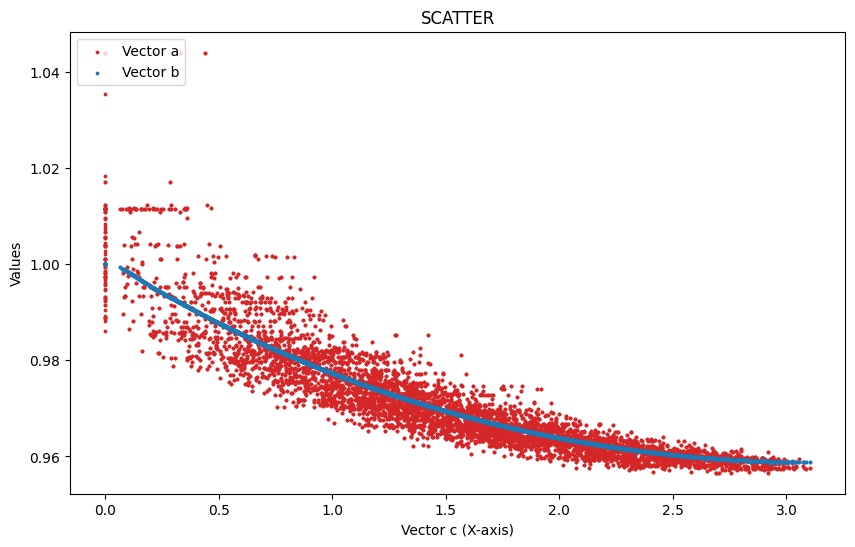

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure data is 1D for plotting (flattening the column vectors)
c = c.flatten()
a = a.flatten()
b = b.flatten()

# 1. Create figure and Axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot both datasets on the same axis
ax1.set_xlabel('Vector c (X-axis)')
ax1.set_ylabel('Values', color='black')  # Single y-axis label for both datasets
ax1.scatter(c, a, c='tab:red', label='Vector a', s=3)
ax1.scatter(c, b, c='tab:blue', label='Vector b', s=3)

# Add legend
ax1.legend(loc='upper left')

# Add title
plt.title('SCATTER')

# Show plot
plt.show()

In [ ]:
np.min(c)

np.float64(0.0)